numpy has concept of masked array
https://numpy.org/doc/stable/reference/maskedarray.html

> A masked array is the combination of a standard numpy.ndarray and a mask. A mask is either nomask, indicating that no value of the associated array is invalid, or an array of booleans that determines for each element of the associated array whether the value is valid or not. When an element of the mask is False, the corresponding element of the associated array is valid and is said to be unmasked. When an element of the mask is True, the corresponding element of the associated array is said to be masked (invalid).

>The package ensures that masked entries are not used in computations.

This is a dead end and NOT USED

In [1]:
import numpy as np
import numpy.ma as npma

from PIL import Image, ImageDraw

import matplotlib
import matplotlib.pyplot as plt

In [2]:
from ls_fringeapp import fringeprocess as fp
from ls_fringeapp.load_equipment_data import repo_folder

Equipment Register loaded from /home/elfnor/gits/Length_Stds_Equipment_Register/register.xml
{'red': 632.991212579, 'green': 532.245576449053}


In [3]:
from plot_helpers import draw_gauge

In [4]:
image_folder = repo_folder / "tests" / "data" / "mock_square_gauges"
img_filename = image_folder / "g1.bmp"

In [5]:
img = Image.open(img_filename)
img = img.convert("L", matrix=(1 / 3.0, 1 / 3.0, 1 / 3.0, 0.0))
img_array = np.asarray(img)


In [6]:
mask = Image.new(mode="1", size=img_array.shape)

In [7]:
draw = ImageDraw.Draw(mask)
draw.ellipse((400, 400, 700, 700), fill="white", outline="white")

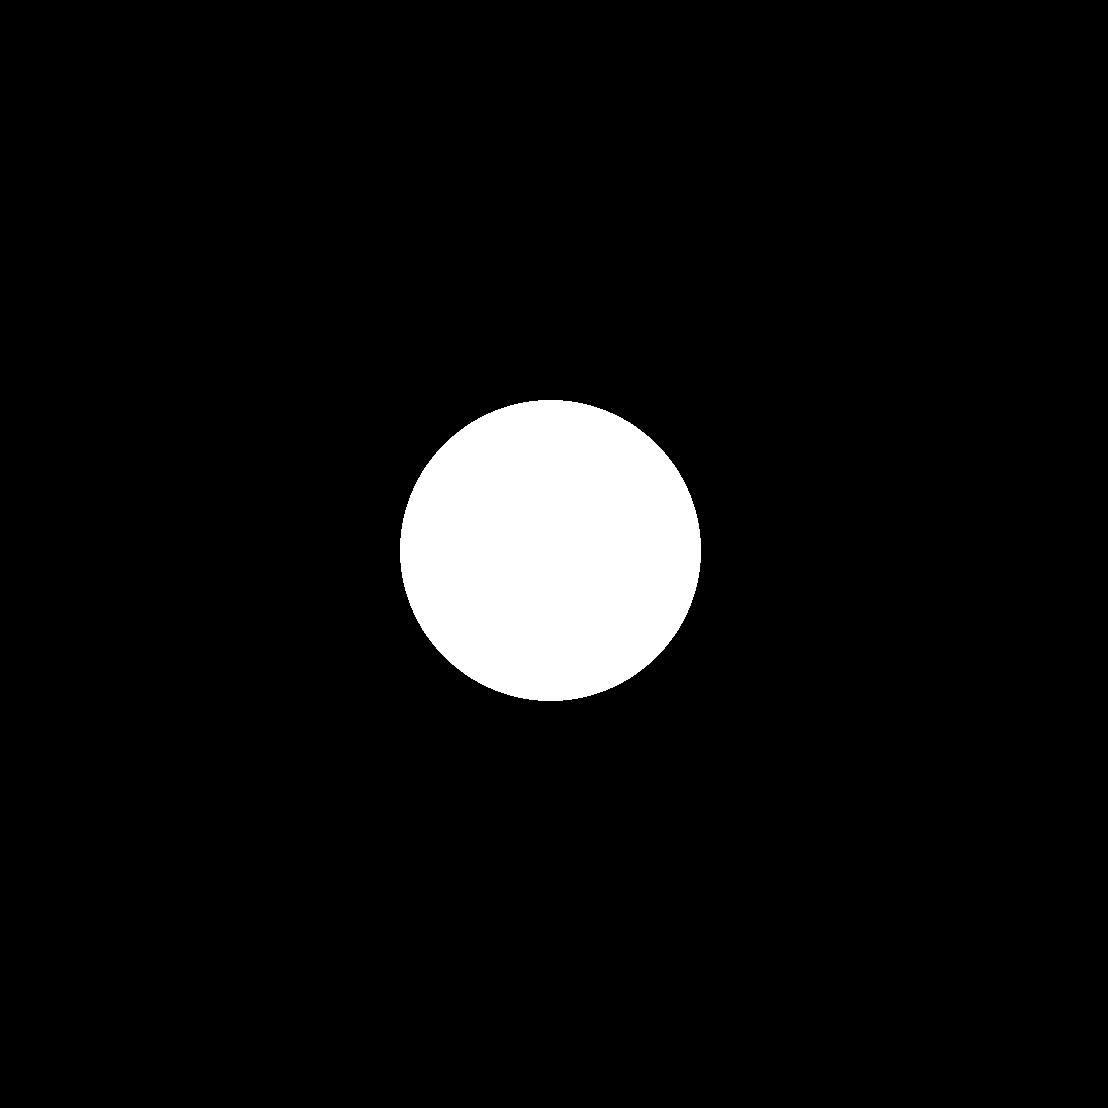

In [8]:
mask

In [9]:
mask_array = np.asarray(mask)

In [10]:
img_array.mean()

np.float64(5.253380403758683)

In [11]:
img_masked = npma.array(img_array, mask=mask_array.astype("bool"))

In [12]:
img_masked.mean()

np.float64(5.273311515287763)

In [13]:
img_masked.mask.sum()

np.int64(71129)

In [14]:
mask_array.sum()

np.int64(71129)

In [15]:
pklist_masked = fp.pkfind(img_masked)

430


In [16]:
len(pklist_masked)

1108

In [17]:
pklist = fp.pkfind(img_array)

430


In [18]:
xygb = np.array(
    [
        [146.0, 180.0],
        [
            931.0,
            180.0,
        ],
        [931.0, 946.0],
    ]
)
ffrac, drawdata = fp.array2frac(img_array, xygb, drawinfo=True)

430


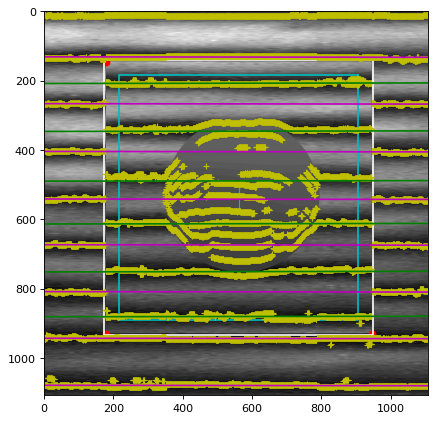

In [19]:
fig = plt.figure(figsize=(6, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
draw_gauge(axes, img_array, drawdata)

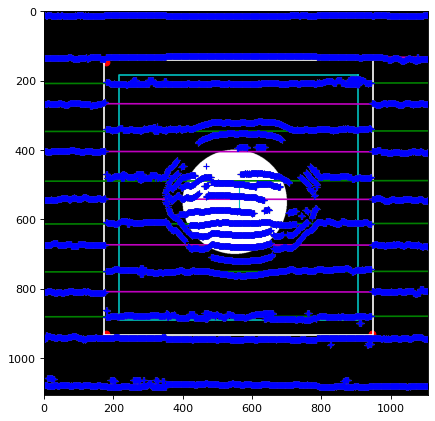

In [20]:
fig = plt.figure(figsize=(6, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
[
    xy,
    co,
    ro,
    ci,
    ri,
    ccen,
    rcen,
    pklist,
    slopep,
    interceptsp,
    slopeg,
    interceptsg,
] = drawdata

axes.imshow(mask_array, cmap=matplotlib.cm.gray)
axes.axis("image")
axes.plot(xy[:, 1], xy[:, 0], "or")
axes.plot(ccen, rcen, "+c", ms=20)
axes.plot(co, ro, "w-")
axes.plot(ci, ri, "c-")
for col, peaks in enumerate(pklist):
    x = col * np.ones_like(peaks)
    axes.plot(x, peaks, "+y")
maxx = img_array.shape[1]
for cepts in interceptsp:
    axes.plot([0, maxx], [cepts, slopep * maxx + cepts], "-m")
for cepts in interceptsg:
    axes.plot([0, maxx], [cepts, slopeg * maxx + cepts], "g-")


for col, peaks in enumerate(pklist_masked):
    x = col * np.ones_like(peaks)
    axes.plot(x, peaks, "+b")

In [21]:
s = img_masked
ncol = s.shape[1]
pklist = []
n = s.shape[0]

for k in range(0, ncol):
    # Get column of sub-image and remove best st line.
    y = matplotlib.mlab.detrend_linear(
        s[:, k]
    )  # remove intensity gradient down the column
    yfft = np.fft.fft(y)
    # Positive frequencies only
    ypos = np.abs(yfft[0 : (n // 2) + 1])  # find the magnitudes of each frequency

    # Find fundamental freq (num fringes per column) - it must be greater than 5 fringes per column
    ypos_trunc = ypos[5:]
    iymax = ypos_trunc.argmax()

    k0 = iymax + 5
    # Use components up to 5*f0
    nharm = 5
    yfft[(nharm * k0 + 2) : n - nharm * k0] = 0
    # Reconstruct time series from selected harmonics
    z = np.real(np.fft.ifft(yfft))
    # this is a list of arrays one array for each column
    # if k == 430:
    #     print(k)
    pkloc = fp.findpeaks2(z)
    pklist.append(pkloc)

In [22]:
s

masked_array(
  data=[[3.3333333333333335, 3.3333333333333335, 3.3333333333333335, ...,
         3.3333333333333335, 3.3333333333333335, 3.3333333333333335],
        [3.6666666666666665, 3.6666666666666665, 3.6666666666666665, ...,
         3.6666666666666665, 3.6666666666666665, 3.6666666666666665],
        [3.6666666666666665, 3.6666666666666665, 3.6666666666666665, ...,
         3.6666666666666665, 3.6666666666666665, 3.6666666666666665],
        ...,
        [3.0, 3.0, 3.0, ..., 3.3333333333333335, 3.3333333333333335,
         3.3333333333333335],
        [2.6666666666666665, 2.6666666666666665, 2.6666666666666665, ...,
         3.6666666666666665, 3.6666666666666665, 3.6666666666666665],
        [3.3333333333333335, 3.3333333333333335, 3.3333333333333335, ...,
         3.6666666666666665, 4.0, 4.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,

In [23]:
s.mask.sum()

np.int64(71129)

In [24]:
k = 550
y = matplotlib.mlab.detrend_linear(s[:, k])

In [25]:
y

array([-4.08911499, -4.08468512, -4.08025525, ...,  0.47255369,
        0.47698356,  0.81474676], shape=(1108,))

In [26]:
yfft = np.fft.fft(s[:, k])
yfft

array([5876.66666667+1.77635684e-15j,  268.35956034-8.94345439e+02j,
         64.49358734-3.05469133e+02j, ...,  169.88250708+2.87786972e+02j,
         64.49358734+3.05469133e+02j,  268.35956034+8.94345439e+02j],
      shape=(1108,))

In [27]:
s[:, k]

masked_array(data=[3.6666666666666665, 3.6666666666666665,
                   3.6666666666666665, ..., 3.3333333333333335,
                   3.3333333333333335, 3.6666666666666665],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)